In [ ]:
import pandas as pd

# Load the Excel file
file_path = '/content/assgn6_train.csv'
data = pd.read_csv(file_path)

# Display the dataframe
data.head()


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import numpy as np
import tensorflow as tf

# Extract labels and images
labels = data['label'].values
images = data.drop(columns=['label']).values

# Normalize pixel values
images = images / 255.0

# Convert to TensorFlow tensors
images = tf.convert_to_tensor(images, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)

# Create a dataset and data loader
dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(buffer_size=1024).batch(64)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, LeakyReLU, Reshape, Concatenate
from tensorflow.keras.models import Model

# Generator
def build_generator(noise_dim, label_dim, image_dim):
    noise_input = Input(shape=(noise_dim,))
    label_input = Input(shape=(1,), dtype=tf.int32)

    label_embedding = Flatten()(Embedding(10, label_dim)(label_input))
    model_input = Concatenate()([noise_input, label_embedding])

    x = Dense(256)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    img_output = Dense(image_dim, activation='tanh')(x)

    return Model([noise_input, label_input], img_output)

# Discriminator
def build_discriminator(image_dim, label_dim):
    img_input = Input(shape=(image_dim,))
    label_input = Input(shape=(1,), dtype=tf.int32)

    label_embedding = Flatten()(Embedding(10, label_dim)(label_input))
    model_input = Concatenate()([img_input, label_embedding])

    x = Dense(512)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    validity_output = Dense(1, activation='sigmoid')(x)

    return Model([img_input, label_input], validity_output)

# Hyperparameters
noise_dim = 100
label_dim = 10
image_dim = images.shape[1]

# Initialize generator and discriminator
generator = build_generator(noise_dim, label_dim, image_dim)
discriminator = build_discriminator(image_dim, label_dim)

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])


In [ ]:
# CGAN model
discriminator.trainable = False

noise_input = Input(shape=(noise_dim,))
label_input = Input(shape=(1,), dtype=tf.int32)
generated_img = generator([noise_input, label_input])
validity = discriminator([generated_img, label_input])

cgan = Model([noise_input, label_input], validity)
cgan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))


In [ ]:
import matplotlib.pyplot as plt

# Function to save generated images
def save_images(epoch, generator, noise_dim, label_dim, num_samples=10):
    noise = np.random.normal(0, 1, (num_samples, noise_dim))
    labels = np.arange(0, 10).reshape(-1, 1)
    generated_imgs = generator.predict([noise, labels])

    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(generated_imgs[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i][0]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_{epoch}.png")
    plt.close()

# Training loop
num_epochs = 5
batch_size = 64

for epoch in range(num_epochs):
    for imgs, labels in dataset:
        batch_size = imgs.shape[0]

        # Real images and labels
        real_imgs = imgs
        real_labels = labels
        real_targets = np.ones((batch_size, 1))

        # Fake images and labels
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        fake_labels = np.random.randint(0, 10, (batch_size, 1))
        fake_imgs = generator.predict([noise, fake_labels])
        fake_targets = np.zeros((batch_size, 1))

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch([real_imgs, real_labels], real_targets)
        d_loss_fake = discriminator.train_on_batch([fake_imgs, fake_labels], fake_targets)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        g_loss = cgan.train_on_batch([noise, fake_labels], real_targets)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} | D Loss: {d_loss[0]} | D Acc.: {100*d_loss[1]}% | G Loss: {g_loss}")

    # Save generated images every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        save_images(epoch + 1, generator, noise_dim, label_dim)


1/1 [==============================] - 0s 30ms/step
Epoch 1/5 | D Loss: 0.22145259380340576 | D Acc.: 87.5% | G Loss: 7.1670732498168945
1/1 [==============================] - 0s 32ms/step
Epoch 2/5 | D Loss: 0.17347942665219307 | D Acc.: 95.3125% | G Loss: 4.986164093017578
1/1 [==============================] - 0s 28ms/step
Epoch 3/5 | D Loss: 0.0710233636200428 | D Acc.: 98.4375% | G Loss: 4.446577072143555
1/1 [==============================] - 0s 31ms/step
Epoch 4/5 | D Loss: 0.14659255743026733 | D Acc.: 96.875% | G Loss: 4.960532188415527
2/2 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 45ms/step


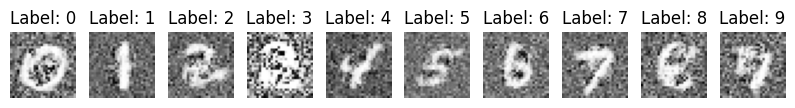

In [ ]:
# Function to generate and visualize samples
def generate_samples(generator, num_samples=10):
    noise = np.random.normal(0, 1, (num_samples, noise_dim))
    labels = np.arange(0, 10).reshape(-1, 1)
    generated_imgs = generator.predict([noise, labels])

    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(generated_imgs[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i][0]}")
        plt.axis('off')
    plt.show()

# Generate and visualize samples
generate_samples(generator)
